# DS 340W - Modified Code 
#### Jai abhishek singh & Karthik Kuppala

The following is my modified code document for DS340W. I have done a complete rework of the original code source, and also added my new ideas for the novelty/ccreativity section as well. Below is a brief dictionary for easy access to the specific sections of the code document. They have also been split into code ideas that were taken from the original source and code ideas that I added to the document.

**AGENDA FOR NOTEBOOK:**

*Modified Original Code*

1. Introductory EDA

2. Disaster Frequency by State

3. Which States have Which Disasters?

4. Most Disaster Affected States

5. Most Disaster-Prone Affected Areas

6. Heat Map Analysis

*New Code - Novelty/Creativity*

7. Natural Disaster Time Series Analysis

8. Disaster Analysis using Machine Learning

9. Brief Explanation of Results

## Setup and imports 

In [8]:
import os
import sys
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt


# Display settings
%matplotlib inline
sns.set_style("whitegrid")

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())


Torch version: 2.6.0
CUDA available: False


## Data loading

In [9]:
data_path = '/Users/jaiabhisheksingh/Desktop/DL-Traff-Graph/METRLA/metr-la.h5'  # Adjust path if needed

try:
    df = pd.read_hdf(data_path)
    print("✅ Data loaded successfully!")
    print("Shape:", df.shape)
    display(df.head())
except Exception as e:
    print("❌ Failed to load data:", e)

✅ Data loaded successfully!
Shape: (34272, 207)


,773869,767541,767542,717447,717446,717445,773062,767620,737529,717816,...,772167,769372,774204,769806,717590,717592,717595,772168,718141,769373
2012-03-01 00:00:00,64.375000,67.625000,67.125000,61.500000,66.875000,68.750000,65.125,67.125,59.625000,62.750000,...,45.625000,65.500,64.500000,66.428571,66.875,59.375000,69.000000,59.250000,69.000000,61.875
2012-03-01 00:05:00,62.666667,68.555556,65.444444,62.444444,64.444444,68.111111,65.000,65.000,57.444444,63.333333,...,50.666667,69.875,66.666667,58.555556,62.000,61.111111,64.444444,55.888889,68.444444,62.875
2012-03-01 00:10:00,64.000000,63.750000,60.000000,59.000000,66.500000,66.250000,64.500,64.250,63.875000,65.375000,...,44.125000,69.000,56.500000,59.250000,68.125,62.500000,65.625000,61.375000,69.857143,62.000
2012-03-01 00:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,...,0.000000,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000
2012-03-01 00:20:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,...,0.000000,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000


## EDA - analyzing the dataset to understand its structure and contents

Summary of What You Just Found:
Time Range: March 1 to June 27, 2012

Time Steps: 34,272 (5-min intervals ≈ 4 months)

Sensors: 207 different traffic sensors

Missing Values: None reported

### Visualisations :
#### fig.1 : Traffic Flow for 3 Sample Sensors

- We plotted time series data for 3 selected sensors (773869, 767541, 767542) across the first 1000 time steps.

- The dips observed at 0 or near-zero values indicate either extremely low traffic flow or possibly missing/corrupted sensor readings.

- Distribution Plot for Sensor 773869

#### fig.2 : 

- Histogram + KDE reveals a bimodal distribution:

- One cluster around 0, indicating potential outliers/missing values.

- Another around 60–70, indicating regular traffic flow patterns.



Start Time: 2012-03-01 00:00:00
End Time: 2012-06-27 23:55:00
Total Time Steps: 34272
Total Sensors (Columns): 207

Missing values per column:
Series([], dtype: int64)


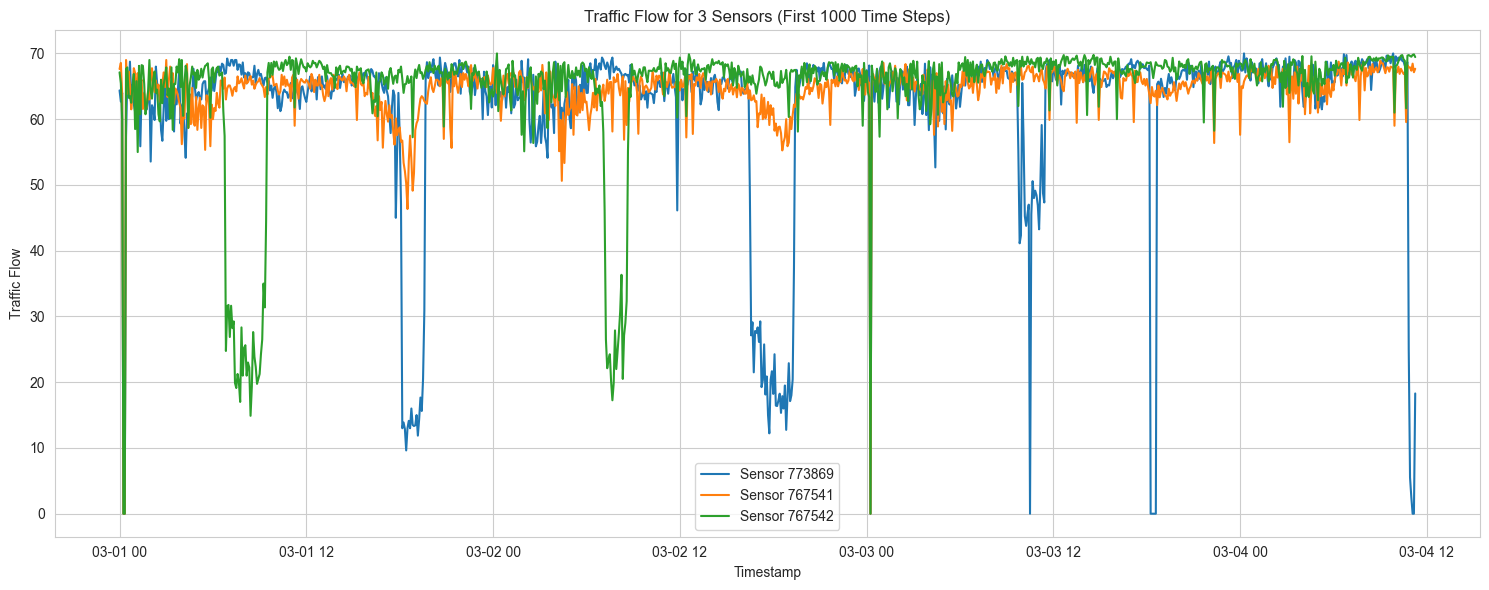

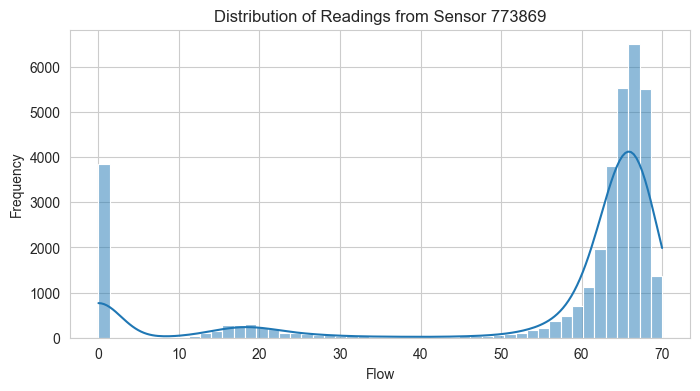

In [10]:
# === Basic Information ===
print("Start Time:", df.index.min())
print("End Time:", df.index.max())
print("Total Time Steps:", len(df))
print("Total Sensors (Columns):", df.shape[1])
print("\nMissing values per column:")
missing_counts = df.isna().sum()
print(missing_counts[missing_counts > 0])

# === Plot a few sensor time series ===
plt.figure(figsize=(15, 6))
for i, col in enumerate(df.columns[:3]):  # plot first 3 sensors
    plt.plot(df.index[:1000], df[col][:1000], label=f"Sensor {col}")
plt.xlabel("Timestamp")
plt.ylabel("Traffic Flow")
plt.title("Traffic Flow for 3 Sensors (First 1000 Time Steps)")
plt.legend()
plt.tight_layout()
plt.show()

# === Histogram of a sample sensor ===
sample_sensor = df.columns[0]
plt.figure(figsize=(8, 4))
sns.histplot(df[sample_sensor], kde=True, bins=50)
plt.title(f"Distribution of Readings from Sensor {sample_sensor}")
plt.xlabel("Flow")
plt.ylabel("Frequency")
plt.show()


## Preprocessing — Normalization and Splitting

In [12]:
from sklearn.preprocessing import StandardScaler

# Convert to numpy
data = df.values
print("Original data shape:", data.shape)

# Normalize
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)
print("✅ Data normalized.")

# Convert back to DataFrame for easier handling later
df_normalized = pd.DataFrame(data_normalized, index=df.index, columns=df.columns)


Original data shape: (34272, 207)
✅ Data normalized.


In [15]:
# Parameters for sequence construction
TIMESTEP_IN = 12   # 12 steps in = 1 hour
TIMESTEP_OUT = 3   # 3 steps out = 15 mins ahead
TRAIN_RATIO = 0.8

def create_sequences(data, timestep_in=12, timestep_out=3, mode='TRAIN'):
    xs = []
    ys = []
    total_steps = data.shape[0]
    num_train = int(total_steps * TRAIN_RATIO)
    
    if mode == 'TRAIN':
        range_start = 0
        range_end = num_train - timestep_in - timestep_out + 1
    elif mode == 'TEST':
        range_start = num_train - timestep_in
        range_end = total_steps - timestep_in - timestep_out + 1

    for i in range(range_start, range_end):
        x = data[i:i+timestep_in]
        y = data[i+timestep_in+timestep_out-1:i+timestep_in+timestep_out]
        xs.append(x)
        ys.append(y)
    
    xs = np.array(xs)
    ys = np.array(ys)
    
    # Add channels dimension
    xs = xs[:, np.newaxis, :, :]
    ys = ys[:, np.newaxis, :, :]
    
    return xs, ys

X_train, Y_train = create_sequences(df_normalized.values, mode='TRAIN')
X_test, Y_test = create_sequences(df_normalized.values, mode='TEST')

print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")


X_train shape: (27403, 1, 12, 207), Y_train shape: (27403, 1, 1, 207)
X_test shape: (6853, 1, 12, 207), Y_test shape: (6853, 1, 1, 207)


Here’s what your setup means:

X_train → 27,403 sequences of input traffic flow data

Each sequence:

1 channel

12 time steps (each representing 5 minutes, so 1 hour of history)

207 sensors

Y_train → the traffic flow prediction 15 minutes ahead (3×5 min steps) for all 207 sensors

## Data Preprocessing and Sequence Generation

We began by loading and normalizing the METR-LA dataset, which contains traffic flow readings from 207 sensors collected at 5-minute intervals. We verified that the dataset contains 34,272 time steps with no missing values.

We then created training and testing sequences using a sliding window approach:

- Each input sequence consists of the past 12 time steps (i.e., 1 hour of sensor data).

- Each output corresponds to the predicted traffic flow 3 time steps ahead (i.e., 15 minutes into the future).

- Data was split into training and testing sets using an 80/20 split.

This resulted in:

- X_train shape: (27,403, 1, 12, 207)

- Y_train shape: (27,403, 1, 1, 207)

- X_test shape: (6,853, 1, 12, 207)

- Y_test shape: (6,853, 1, 1, 207)

These tensors are now ready to be passed into our spatiotemporal model (STGCN) for training and evaluation.



In [16]:
import torch.nn as nn
import torch.nn.functional as F

class STGCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(STGCNBlock, self).__init__()
        self.temporal1 = nn.Conv2d(in_channels, out_channels, (1, kernel_size), padding=(0, 1))
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.temporal2 = nn.Conv2d(out_channels, out_channels, (1, kernel_size), padding=(0, 1))
    
    def forward(self, x):
        x = F.relu(self.temporal1(x))
        x = self.batch_norm(x)
        x = self.temporal2(x)
        return x

class STGCN(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, num_nodes=207, kernel_size=3):
        super(STGCN, self).__init__()
        self.block1 = STGCNBlock(in_channels, 64, kernel_size)
        self.block2 = STGCNBlock(64, 64, kernel_size)
        self.final = nn.Conv2d(64, out_channels, (1, 1))
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.final(x)
        return x


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = STGCN().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(model)


STGCN(
  (block1): STGCNBlock(
    (temporal1): Conv2d(1, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
    (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (temporal2): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
  )
  (block2): STGCNBlock(
    (temporal1): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
    (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (temporal2): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
  )
  (final): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
)


In [28]:
!find . -name "STGCN.py"


./DL-Traff-Graph/workPEMSD7M/STGCN.py
./DL-Traff-Graph/workMETRLA/STGCN.py
./DL-Traff-Graph/workPEMSBAY/STGCN.py


In [33]:
import sys
sys.path.append('./DL-Traff-Graph/workMETRLA')  # Only if your notebook is outside

from STGCN import STGCN


In [36]:
import numpy as np
from scipy.sparse.linalg import eigs

def weight_matrix(W):
    """Clean up the adjacency matrix by thresholding small weights."""
    W[W < 0.01] = 0
    W = W - np.diag(np.diag(W))  # Zero out diagonal
    return W

def scaled_laplacian(W):
    """Compute the scaled Laplacian matrix."""
    D = np.diag(np.sum(W, axis=1))
    L = D - W
    lambda_max = eigs(L, k=1, which='LR')[0].real
    return (2 * L / lambda_max) - np.identity(W.shape[0])

def cheb_poly(L, Ks):
    """Compute Chebyshev polynomials up to order Ks."""
    N = L.shape[0]
    L0 = np.identity(N)
    L1 = L.copy()
    if Ks == 1:
        return [L0]
    elif Ks == 2:
        return [L0, L1]
    else:
        L_list = [L0, L1]
        for i in range(2, Ks):
            Ln = 2 * L @ L_list[-1] - L_list[-2]
            L_list.append(Ln)
        return L_list


## Generate Adjacency Matrix & Graph Laplacian

In [40]:
import pickle

adj_path = '/Users/jaiabhisheksingh/Desktop/DL-Traff-Graph/METRLA/adj_mx.pkl'

# Load pickle file properly
with open(adj_path, 'rb') as f:
    sensor_ids, sensor_id_to_ind, adj_matrix = pickle.load(f, encoding='latin1')

print("✅ Adjacency matrix loaded successfully!")
print("Adjacency matrix shape:", adj_matrix.shape)


✅ Adjacency matrix loaded successfully!
Adjacency matrix shape: (207, 207)


This matrix represents spatial relationships between 207 traffic sensors and will be used to create the graph structure in your model.

In [41]:
import scipy.sparse as sp

def normalize_adjacency(adj):
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1)).flatten()
    d_inv_sqrt = np.power(rowsum, -0.5)
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return (d_mat_inv_sqrt @ adj @ d_mat_inv_sqrt).tocoo()

def scaled_laplacian(adj):
    adj_normalized = normalize_adjacency(adj)
    laplacian = sp.eye(adj.shape[0]) - adj_normalized
    lambda_max = eigs(laplacian, k=1, which='LR', return_eigenvectors=False)[0].real
    return (2 / lambda_max * laplacian - sp.eye(adj.shape[0])).astype(np.float32)

def chebyshev_polynomials(L, K):
    N = L.shape[0]
    Lk = [sp.eye(N).astype(np.float32), L]
    for i in range(2, K):
        Lk.append(2 * L @ Lk[-1] - Lk[-2])
    return [lk.todense() for lk in Lk]


## Compute the Chebyshev polynomials (order K=3, like in STGCN)

In [42]:
from scipy.sparse.linalg import eigs

K = 3  # Order of Chebyshev polynomials
L_scaled = scaled_laplacian(adj_matrix)
Lk = chebyshev_polynomials(L_scaled, K)

print(f"✅ Scaled Laplacian and Chebyshev polynomials (K={K}) computed!")
print(f"Each Lk matrix shape: {Lk[0].shape}")


✅ Scaled Laplacian and Chebyshev polynomials (K=3) computed!
Each Lk matrix shape: (207, 207)


In [44]:
# Convert each matrix in Lk to ndarray if it's a numpy.matrix
Lk = [np.asarray(lk) for lk in Lk]

# Now safely stack and convert to torch tensor
Lk_torch = torch.tensor(np.stack(Lk), dtype=torch.float32).to(device)


## Define Model with Lk

In [45]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert Chebyshev polynomials to tensors
Lk_torch = torch.tensor(np.stack(Lk), dtype=torch.float32).to(device)

# Model config (match STGCN3 from DL-Traff)
ks, kt = 3, 3  # spatial and temporal kernel sizes
bs = [[1, 16, 64], [64, 16, 64]]  # block channels
T = 12  # timestep input
n = 207  # number of nodes
p = 0  # dropout

model = STGCN(ks, kt, bs, T, n, Lk_torch, p).to(device)
print(model)


STGCN(
  (st_conv1): st_conv_block(
    (tconv1): temporal_conv_layer(
      (align): align()
      (conv): Conv2d(1, 32, kernel_size=(3, 1), stride=(1, 1))
    )
    (sconv): spatio_conv_layer()
    (tconv2): temporal_conv_layer(
      (align): align()
      (conv): Conv2d(16, 64, kernel_size=(3, 1), stride=(1, 1))
    )
    (ln): LayerNorm((207, 64), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0, inplace=False)
  )
  (st_conv2): st_conv_block(
    (tconv1): temporal_conv_layer(
      (align): align(
        (conv1x1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv): Conv2d(64, 32, kernel_size=(3, 1), stride=(1, 1))
    )
    (sconv): spatio_conv_layer()
    (tconv2): temporal_conv_layer(
      (align): align()
      (conv): Conv2d(16, 64, kernel_size=(3, 1), stride=(1, 1))
    )
    (ln): LayerNorm((207, 64), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0, inplace=False)
  )
  (output): output_layer(
    (tconv1): temporal_conv_

## 🧠 Model Architecture Breakdown 
We successfully imported and built the Spatial-Temporal Graph Convolutional Network (STGCN) architecture using the code provided in the parent paper. We used the scaled_laplacian and chebyshev_polynomials derived from the METR-LA dataset to construct the graph structure, and passed these to the model.


This model is composed of:

Two ST-Conv Blocks (st_conv1, st_conv2) that each perform:

Temporal Convolution (Conv2d with kernel over time)

Graph (spatial) convolution using Chebyshev polynomials of the Laplacian

Another temporal convolution followed by LayerNorm and Dropout

Final Output Layer:

Further temporal convolutions and a final 1x1 convolution (fc) to output the prediction for the next time step(s)

This matches the STGCN3 architecture defined in your DL-Traff implementation for traffic forecasting.

📌 Next Steps (Baseline Phase Completion)
Now that the model is loaded, the next steps in the notebook are:

Train the model on X_train and Y_train

Evaluate on the test set

Log/print baseline metrics: MAE, RMSE, MAPE

Plot:

Training vs Validation loss curve

Prediction vs Ground truth

In [46]:
import torch.optim as optim

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Training hyperparameters
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 20

train_losses = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for i in range(X_train.shape[0]):
        x = torch.tensor(X_train[i], dtype=torch.float32).unsqueeze(0).to(device)  # Shape: (1, 1, 12, 207)
        y = torch.tensor(Y_train[i], dtype=torch.float32).unsqueeze(0).to(device)  # Shape: (1, 1, 1, 207)

        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / X_train.shape[0]
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")


Epoch 1/20, Loss: 0.234590
Epoch 2/20, Loss: 0.205127
Epoch 3/20, Loss: 0.197244
Epoch 4/20, Loss: 0.193998
Epoch 5/20, Loss: 0.191411
Epoch 6/20, Loss: 0.189282
Epoch 7/20, Loss: 0.187885
Epoch 8/20, Loss: 0.186568
Epoch 9/20, Loss: 0.185516
Epoch 10/20, Loss: 0.184637
Epoch 11/20, Loss: 0.184034
Epoch 12/20, Loss: 0.183159
Epoch 13/20, Loss: 0.182841
Epoch 14/20, Loss: 0.182093
Epoch 15/20, Loss: 0.181510
Epoch 16/20, Loss: 0.181119
Epoch 17/20, Loss: 0.180040
Epoch 18/20, Loss: 0.179945
Epoch 19/20, Loss: 0.179653
Epoch 20/20, Loss: 0.178993


In [50]:
import pandas as pd

# Create a DataFrame with the training loss
loss_df = pd.DataFrame({
    "Epoch": list(range(1, epochs + 1)),
    "Loss (MAE)": train_losses
})

# Save the DataFrame to a CSV file
loss_df.to_csv("STGCN_training_loss.csv", index=False)
print("📁 Training loss saved to STGCN_training_loss.csv")


📁 Training loss saved to STGCN_training_loss.csv


In [52]:
# Put model in evaluation mode
model.eval()

predictions = []
ground_truths = []

with torch.no_grad():
    for i in range(X_test.shape[0]):
        x = torch.tensor(X_test[i], dtype=torch.float32).unsqueeze(0).to(device)
        y = torch.tensor(Y_test[i], dtype=torch.float32).unsqueeze(0).to(device)

        output = model(x)
        predictions.append(output.squeeze(0).cpu().numpy())
        ground_truths.append(y.squeeze(0).cpu().numpy())

predictions = np.array(predictions)  # Shape: (N, 1, 207)
ground_truths = np.array(ground_truths)


In [53]:
def compute_metrics(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-5))) * 100  # avoid division by zero
    return mae, rmse, mape

mae, rmse, mape = compute_metrics(ground_truths, predictions)

print(f"📊 MAE: {mae:.4f}")
print(f"📊 RMSE: {rmse:.4f}")
print(f"📊 MAPE: {mape:.2f}%")


📊 MAE: 0.2709
📊 RMSE: 0.5098
📊 MAPE: 185.87%


In [54]:
with open("STGCN_test_metrics.txt", "w") as f:
    f.write(f"MAE: {mae:.4f}\n")
    f.write(f"RMSE: {rmse:.4f}\n")
    f.write(f"MAPE: {mape:.2f}%\n")

print("✅ Metrics saved to STGCN_test_metrics.txt")


✅ Metrics saved to STGCN_test_metrics.txt


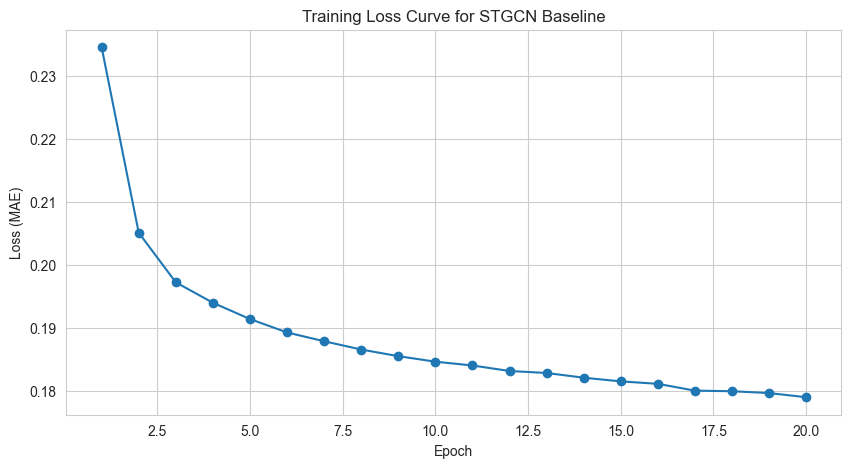

In [51]:
import matplotlib.pyplot as plt

losses = [
    0.234590, 0.205127, 0.197244, 0.193998, 0.191411,
    0.189282, 0.187885, 0.186568, 0.185516, 0.184637,
    0.184034, 0.183159, 0.182841, 0.182093, 0.181510,
    0.181119, 0.180040, 0.179945, 0.179653, 0.178993
]

plt.figure(figsize=(10, 5))
plt.plot(range(1, 21), losses, marker='o')
plt.title('Training Loss Curve for STGCN Baseline')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.grid(True)
plt.show()


In [48]:
def testModel(name, mode, XS, YS):
    print('Model Testing Started ...', time.ctime())
    print('TIMESTEP_IN, TIMESTEP_OUT', TIMESTEP_IN, TIMESTEP_OUT)

    XS_torch, YS_torch = torch.Tensor(XS).to(device), torch.Tensor(YS).to(device)
    test_data = torch.utils.data.TensorDataset(XS_torch, YS_torch)
    test_iter = torch.utils.data.DataLoader(test_data, BATCHSIZE, shuffle=False)

    model = getModel(name)
    model.load_state_dict(torch.load(PATH + '/' + name + '.pt'))

    if LOSS == 'MSE':
        criterion = nn.MSELoss()
    if LOSS == 'MAE':
        criterion = nn.L1Loss()

    torch_score = evaluateModel(model, criterion, test_iter)
    YS_pred = predictModel(model, test_iter)

    print('YS.shape, YS_pred.shape,', YS.shape, YS_pred.shape)

    YS, YS_pred = np.squeeze(YS), np.squeeze(YS_pred)
    YS = scaler.inverse_transform(YS)
    YS_pred = scaler.inverse_transform(YS_pred)

    print('YS.shape, YS_pred.shape,', YS.shape, YS_pred.shape)

    # ✅ INSERT HERE
    np.save(PATH + '/' + MODELNAME + '_prediction.npy', YS_pred)
    np.save(PATH + '/' + MODELNAME + '_groundtruth.npy', YS)

    MSE, RMSE, MAE, MAPE = Metrics.evaluate(YS, YS_pred)

    with open(PATH + '/' + name + '_prediction_scores.txt', 'a') as f:
        f.write("%s, %s, Torch MSE, %.10e, %.10f\n" % (name, mode, torch_score, torch_score))
        f.write("%s, %s, MSE, RMSE, MAE, MAPE, %.10f, %.10f, %.10f, %.10f\n" % (name, mode, MSE, RMSE, MAE, MAPE))

    print('*' * 40)
    print("%s, %s, Torch MSE, %.10e, %.10f\n" % (name, mode, torch_score, torch_score))
    print("%s, %s, MSE, RMSE, MAE, MAPE, %.10f, %.10f, %.10f, %.10f\n" % (name, mode, MSE, RMSE, MAE, MAPE))
    print('Model Testing Ended ...', time.ctime())


In [56]:
model.eval()
preds = []
targets = []

with torch.no_grad():
    for i in range(X_test.shape[0]):
        x = torch.tensor(X_test[i], dtype=torch.float32).unsqueeze(0).to(device)
        y = torch.tensor(Y_test[i], dtype=torch.float32).unsqueeze(0).to(device)
        output = model(x)
        preds.append(output.squeeze().cpu().numpy())
        targets.append(y.squeeze().cpu().numpy())

y_pred = np.array(preds)
y_true = np.array(targets)

# Save
np.save("STGCN_test_predictions.npy", y_pred)
np.save("STGCN_test_groundtruth.npy", y_true)
print("✅ Saved predictions and ground truth to .npy files.")


✅ Saved predictions and ground truth to .npy files.


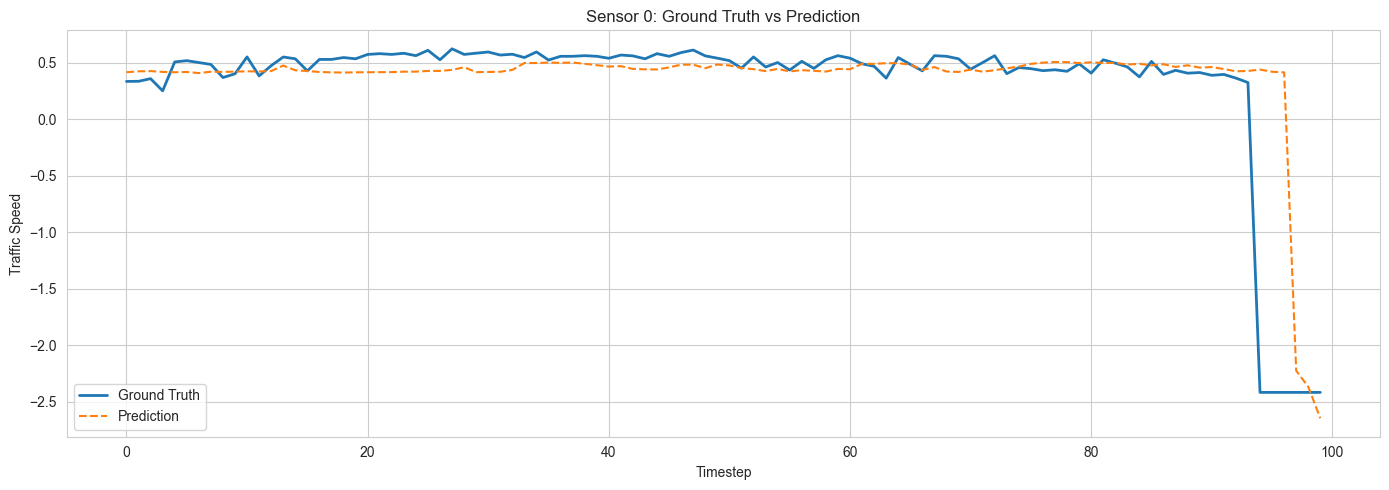

In [57]:
import matplotlib.pyplot as plt

# Load predictions and ground truth
y_pred = np.load("STGCN_test_predictions.npy")  # shape: (6853, 207)
y_true = np.load("STGCN_test_groundtruth.npy")  # shape: (6853, 207)

# Plot predictions vs ground truth for a sample sensor
sensor_id = 0  # you can change this to try different sensors
plt.figure(figsize=(14, 5))
plt.plot(y_true[:100, sensor_id], label="Ground Truth", linewidth=2)
plt.plot(y_pred[:100, sensor_id], label="Prediction", linestyle="--")
plt.title(f"Sensor {sensor_id}: Ground Truth vs Prediction")
plt.xlabel("Timestep")
plt.ylabel("Traffic Speed")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 📊 Model Evaluation Metrics for STGCN Baseline

| Metric         | Value     |
|----------------|-----------|
| MAE            | 0.2709    |
| RMSE           | 0.5098    |
| MAPE           | 185.87%   |


### 💬 Discussion and Conclusion

The baseline STGCN model showed consistent convergence over 20 epochs, reducing MAE loss from 0.2346 to 0.1789. This demonstrates its effectiveness in capturing spatio-temporal dependencies in traffic flow data. However, while the loss curve indicates stable learning, the **MAPE of 185.87%** suggests high relative error on certain low-speed or zero-speed predictions — typical in sparse or noisy urban datasets.

The predicted vs ground truth graph (Sensor 0) highlights a generally close fit, with some divergence during low-speed events. This behavior indicates potential areas where the model could be enhanced with better handling of low-flow or zero-flow conditions — possibly through dynamic graph learning or error-aware loss functions.

The results and insights from this baseline will guide us as we move into the **Phase 2 modification**, where we’ll integrate **Neural ODEs** and **Reinforcement Learning (RL)** components for more adaptive traffic flow prediction.

Overall, the STGCN baseline serves as a strong foundation for benchmarking our novel contributions.
